# CROSS VALIDATION : N FOLD (LOOCV)

<br>

## Introduction

<br>
When <b>the number of folds equals the number of samples</b> ($k = N$), we refer to k-fold cross-validation as <b>leave-one-out cross-validation (LOOCV)</b>. 

<br>
In each iteration of LOOCV, we fit a model to $N - 1$ samples of the dataset and evaluate it on the single, remaining data point. Although this process is <b>computationally expensive</b> ($N$ iterations), it can be <b>particularly useful for small datasets</b>,  where withholding data from the training set would be too wasteful.


<img src="images/n-fold-summary.png" width="50%" height="50%">

In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

#import sklearn.linear_model as lm
import sklearn.neighbors as nbr
from sklearn.model_selection import KFold
import sklearn.metrics as mtr

import utilcompute as uc
from pprint import pprint


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_iris().data, load_iris().target) )
df = pd.DataFrame(data)
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'species']

#print('df.shape[0] : ', df.shape[0])


In [3]:
#df.describe()

In [4]:
# DATA PREPROCESSING : deleting features

to_delete = []
cols = [c for c in df.columns.values.tolist() if (c not in to_delete)]
df = df[cols]

#print('columns : ', df.columns.values.tolist())

In [5]:
target = 'species'
if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [6]:
# DATA PREPROCESSING : features standardization

vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

print()

df_std = uc.standardize(df = df, included = features, excluded = target)

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'petal length': 173.96896536339727,
 'petal width': 55.48868864572551,
 'sepal length': 264.7457109493044,
 'sepal width': 97.111605833803296}

df_std : 

{'petal length': 31.397291650719751,
 'petal width': 16.141563956997683,
 'sepal length': 7.1031134428332869,
 'sepal width': 2.0990386257420881}


In [7]:
# DATA PREPROCESSING : vif subset selection [reduces multicollinearity]

VIF = False

if (VIF):
    selected_features = uc.vif_best_subset_selection(
        vif_threshold = 5, 
        df = df_std, 
        features = features, 
        level = len(features), 
        debug = False
    )
    t = uc.concatenate(features, target)
    df_std = df_std[t]
    
    vif_dict = uc.compute_vif(df = df_std, features = selected_features)
    pprint(vif_dict)
else:
    selected_features = features


In [8]:
# DATA PREPROCESSING : final setup

df = df_std
features = selected_features

print(df_std.columns.values)

['petal length' 'petal width' 'sepal length' 'sepal width' 'species']


In [9]:
# GLOBAL PARAMETERS 

n_splits = len(df)

print('k (# of folds) : ', n_splits)


k (# of folds) :  150


In [10]:
print(df[target].unique())

[ 0.  1.  2.]


In [11]:
columns = ['iteration', 'err_train', 'err_test']
results_df = pd.DataFrame(data = None, index = None, columns = columns)

kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :

    fold_train = df.iloc[train_positions]   
    fold_test = df.iloc[test_positions]  
    
    # if (k == 0):
    #    print('train indices : {0} - {1}'.format(fold_train.index.values[:3], fold_train.index.values[-3:]))
    #    print('test  indices : {0} - {1}'.format(fold_test.index.values[:3], fold_test.index.values[-3:]))
    #    print()

    #model = lm.LogisticRegression()
    model = nbr.KNeighborsClassifier(n_neighbors = 5)
    model.fit(fold_train[features], fold_train[target])

    y_pred_train = model.predict(fold_train[features])
    y_pred_test = model.predict(fold_test[features])
    
    #metrics_train = uc.compute_classification_metrics(y = fold_train[target], y_pred = y_pred_train)
    #metrics_test = uc.compute_classification_metrics(y = fold_test[target], y_pred = y_pred_test)
    
    acc_train = mtr.accuracy_score(y_true = fold_train[target], y_pred = y_pred_train, normalize = True, sample_weight = None)
    acc_test = mtr.accuracy_score(y_true = fold_test[target], y_pred = y_pred_test, normalize = True, sample_weight = None)
    
    values_dict = {
        'iteration' : k + 1,            
        #'err_train' : 1 - metrics_train['ACCURACY'],
        #'err_test' : 1 - metrics_test['ACCURACY'],
        'err_train' : 1 - acc_train,
        'err_test' : 1 - acc_test,
    }
    
    results_index = k
    results_df.loc[results_index] = values_dict     
    

results_df = results_df.astype(dtype = 'float')
#print(results_df)


In [14]:
print()
print('train | err mean : ', results_df['err_train'].mean())
print('train | err std  : ', results_df['err_train'].std())

print()
print('test  | err mean : ', results_df['err_test'].mean())
print('test  | err std  : ', results_df['err_test'].std())



train | err mean :  0.046219239373601693
train | err std  :  0.0029646130171116086

test  | err mean :  0.05333333333333334
test  | err std  :  0.2254500842585117


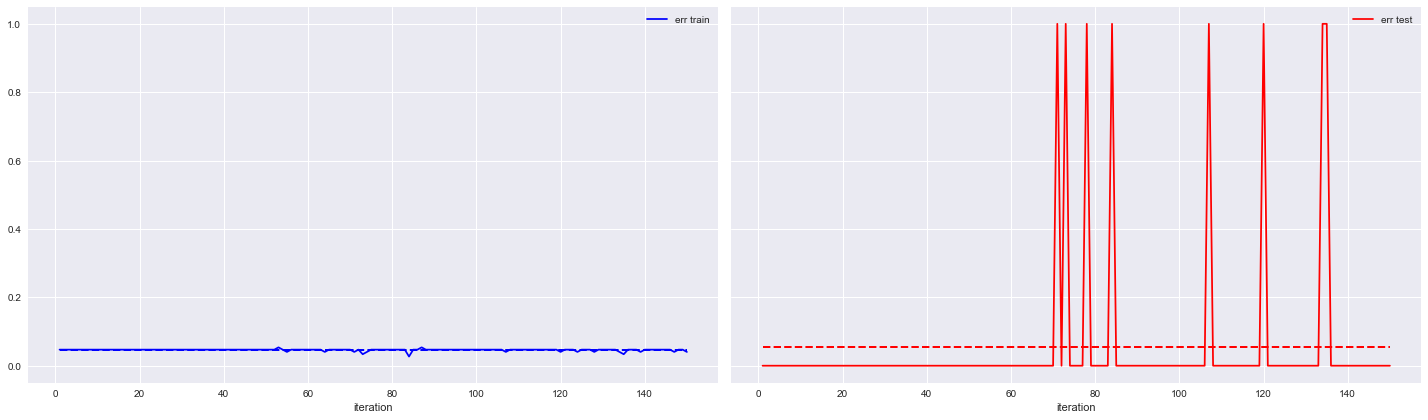

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 6), sharey = True) 

it_min = results_df['iteration'].min()
it_max = results_df['iteration'].max()

err_train_mean = results_df['err_train'].mean()
err_test_mean = results_df['err_test'].mean()

axs[0].plot(results_df['iteration'], results_df['err_train'], color = 'blue', label = 'err train')
axs[0].plot( (it_min, it_max), (err_train_mean, err_train_mean), color = 'blue', lw = 2, linestyle = '--')
axs[0].set_xlabel('iteration')
axs[0].legend(loc = 'best')

axs[1].plot(results_df['iteration'], results_df['err_test'], color = 'red', label = 'err test')
axs[1].plot( (it_min, it_max), (err_test_mean, err_test_mean), color = 'red', lw = 2, linestyle = '--')
axs[1].set_xlabel('iteration')
axs[1].legend(loc = 'best')

plt.tight_layout()
plt.show()

## Considerations

<br>
We can consider the LOOCV estimate of the generalization performance as being <b>approximately unbiased</b>: the pessimistic bias of LOOCV is intuitively lower compared to $k < N$-fold cross validation, <b>since almost all training samples are available for model fitting</b>.

<br>
While LOOCV is almost unbiased, one downside over k-fold cross-validation is the <b>large variance</b> of the LOOCV estimate. It is often said that LOOCV :

<br>
<blockquote>
    has high variance because the test set only contains one sample (Tan and others, 2005)
</blockquote>
<blockquote>
    is highly variable, since it is based upon a single observation (Gareth and others, 2013)
</blockquote>

<br>
These statements are certainly true if we refer to the variance between folds, which is a poor estimate of the variance of the LOOCV estimate : the variability due to randomness in our training data. 

We can estimate the variability of a statistic (here the generalization performance of the model) from the variability of that statistic between sub-samples; in other words, the difference in the results that we would get if we repeated the resampling procedure multiple times on different data samples from the underlying distribution. 

<br>Thus, a more interesting point has been made by Hastie, Tibshirani, and Friedman :

<br>
<blockquote>
    with $k = N$, the cross validation estimator is approximately unbiased for the true (expected) prediction error, but can
    have high variance <b>because the N training sets are so similar to one another</b> (Hastie and others, 2009)
</blockquote>

<br>
We can attribute the high variance of LOOCV to the well-known fact that the mean of highly correlated variables has a higher variance than the mean of variables that are not highly correlated. 

<br>
LOOCV guarantees a non-stratified sample (there is only one data point in the test set).

<br>
As already mentioned in the introduction, the high computational cost of LOOCV is only justified for small datasets, situations where withholding data from the training set would compromise the estimate.

## References

<br>
<ul style="list-style-type:square">
    <li>
         Sebastian Raschka - 
         <a href="https://bit.ly/2LEwbSN">
         Model evaluation, model selection, and algorithm selection in machine learning - Part III</a>        
    </li>
</ul>